In [86]:
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import os
from os.path import join as pjoin

from utils import is_number

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')


# Rekreowanie modelu z artykułu

In [4]:
def data_preprocess():
    path_train = './data/time_series_375_prerpocess_en.xlsx'  # to_ml
    data_df_unna = read_train_data(path_train)

    # data_pre_df = pd.read_csv('./data/sample29_v3.csv',encoding='gbk')
    data_pre_df = pd.read_excel('./data/time_series_test_110_preprocess_en.xlsx', index_col=[0, 1],engine='openpyxl')
    data_pre_df = merge_data_by_sliding_window(data_pre_df, n_days=1, dropna=True, subset=top3_feats_cols,
                                                     time_form='diff')
    data_pre_df = data_pre_df.groupby('PATIENT_ID').first().reset_index()
    data_pre_df = data_pre_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_pre_df = data_pre_df.drop_duplicates()

    return data_df_unna, data_pre_df



def single_tree(cols=['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']):
    print('single_tree:\n')
    #获取375病人（data_df_unna） 和110病人（data_pre_df）数据
    data_df_unna,data_pre_df = data_preprocess()
    #去掉全空行，此时375总数目变成351
    data_df_unna = data_df_unna.dropna(subset=cols,how='any')

    cols.append('Type2')
    #获取病人的结局标签
    Tets_Y = data_pre_df.reset_index()[['PATIENT_ID','outcome']].copy()
    #修改dataframe的名字
    Tets_Y = Tets_Y.rename(columns={'PATIENT_ID': 'ID', 'outcome': 'Y'})
    # 获取110病人的标签数据
    y_true = Tets_Y['Y'].values

    x_col = cols[:-1]
    y_col = cols[-1]
    # 获取351病人的三特征数据
    x_np = data_df_unna[x_col].values
    # 获取351病人的标签数据
    y_np = data_df_unna[y_col].values
    # 获取110病人的三特征数据
    x_test = data_pre_df[x_col].values
    # 在351病人上划分训练集和验证集，此时110视为测试集
    X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.3, random_state=6)
    #限定单树xgb模型
    model = xgb.XGBClassifier(
        max_depth=3,
        n_estimators=1,
    )
    model.fit(X_train,y_train)

    #训练集混淆矩阵
    pred_train = model.predict(X_train)
    #show_confusion_matrix(y_train, pred_train)
    print(classification_report(y_train, pred_train))

    #验证集混淆矩阵
    pred_val = model.predict(X_val)
    #show_confusion_matrix(y_val, pred_val)
    print(classification_report(y_val, pred_val))
    #测试集混淆矩阵
    
    pred_test = model.predict(x_test)
    print('True test label:',y_true)
    print('Predict test label:',pred_test.astype('int32'))
    #show_confusion_matrix(y_true, pred_test)
    print(classification_report(y_true, pred_test))
    
    plt.figure(dpi=300,figsize=(8,6))
    plot_tree(model)
    plt.show()
    
    graph = xgb.to_graphviz(model)
    graph.render(filename='single-tree.dot')
    #单树可视化
    #ceate_feature_map(cols[:-1])
    #graph = xgb.to_graphviz(model, fmap='xgb.fmap', num_trees=0, **{'size': str(10)})
    #graph.render(filename='single-tree.dot')
    
def features_selection():
    ## 读取375的数据
    X_data_all_features,Y_data,x_col = data_read_and_split()
    # name_dict = {'乳酸脱氢酶':'Lactate dehydrogenase (LDH)','淋巴细胞(%)':'Lymphocytes(%)','超敏C反应蛋白':'High-sensitivity C-reactive protein (hs-CRP)',
    #          '钠':'Sodium','氯':'Chlorine','国际标准化比值':'International Normalized Ratio (INR)','嗜酸细胞(#)':'Eosinophils(#)',
    #          '嗜酸细胞(%)':'Eosinophils(%)','单核细胞(%)':'Monocytes(%)','白蛋白':'Albumin'}
    #
    # 构建一个dataframe用于存储特征的重要程度信息
    import_feature = pd.DataFrame()
    import_feature['col'] = x_col
    import_feature['xgb'] = 0
    # 重复100次试验
    for i in range(100): # 50,150
        #每次试验将375数据随机划分0.7训练集和0.3测试集，注意随机random_state=i
        ## 注明：此方法原因是由于可获得的样本量较少，为了产生不同的训练样本集，使得特征的重要度排序更为稳定，从而选择了这样一种方式。
        ## 通过每次不同的随机种子产生不同的样本，从而达到一定程度上的抑制少量样本的异常对特征的重要度带来的影响。
        x_train, x_test, y_train, y_test = train_test_split(X_data_all_features, Y_data, test_size=0.3, random_state=i)
        #定义模型超参数
        model = xgb.XGBClassifier(
                max_depth=4
                ,learning_rate=0.2
                ,reg_lambda=1
                ,n_estimators=150
                ,subsample = 0.9
                ,colsample_bytree = 0.9)
        #模型拟合
        model.fit(x_train, y_train)
        #累加特征重要程度
        import_feature['xgb'] = import_feature['xgb']+model.feature_importances_/100
    # 按照特征重要程度，降序排列
    import_feature = import_feature.sort_values(axis=0, ascending=False, by='xgb')
    print('Top 10 features:')
    print(import_feature.head(10))
    # Sort feature importances from GBC model trained earlier
    # 按照特征重要程度的位置信息
    indices = np.argsort(import_feature['xgb'].values)[::-1]
    #获取前10个重要的特征位置
    Num_f = 10
    indices = indices[:Num_f]
    
    # Visualise these with a barplot
    # plt.subplots(dpi=400,figsize=(12, 10))
    plt.subplots(figsize=(12, 10))
    # g = sns.barplot(y=list(name_dict.values())[:Num_f], x = import_feature.iloc[:Num_f]['xgb'].values[indices], orient='h') #import_feature.iloc[:Num_f]['col'].values[indices]
    g = sns.barplot(y=import_feature.iloc[:Num_f]['col'].values[indices], x = import_feature.iloc[:Num_f]['xgb'].values[indices], orient='h') #import_feature.iloc[:Num_f]['col'].values[indices]
    g.set_xlabel("Relative importance",fontsize=18)
    g.set_ylabel("Features",fontsize=18)
    g.tick_params(labelsize=14)
    sns.despine() 
    # plt.savefig('feature_importances_v3.png')
    plt.show()
    # g.set_title("The mean feature importance of XGB models");
    # 获取前10重要特征的重要性数值
    import_feature_cols= import_feature['col'].values[:10]

    # 画特征金字塔
    num_i = 1
    val_score_old = 0
    val_score_new = 0
    while val_score_new >= val_score_old:
        val_score_old = val_score_new
        # 按重要程度顺序取特种
        x_col = import_feature_cols[:num_i]
        print(x_col)
        X_data = X_data_all_features[x_col]#.values
        ## 交叉验证
        print('5-Fold CV:')
        acc_train, acc_val, acc_train_std, acc_val_std = StratifiedKFold_func_with_features_sel(X_data.values,Y_data.values)
        print("Train AUC-score is %.4f ; Validation AUC-score is %.4f" % (acc_train,acc_val))
        print("Train AUC-score-std is %.4f ; Validation AUC-score-std is %.4f" % (acc_train_std,acc_val_std))
        val_score_new = acc_val
        num_i += 1
        
    print('Selected features:',x_col[:-1])
    
    return list(x_col[:-1])



### Data read and split
def data_read_and_split(is_dropna=False,sub_cols=None):
    # data_df_unna为375数据集，data_pre_df为110数据集
    data_df_unna,data_pre_df = data_preprocess()
    if is_dropna==True:
        data_df_unna = data_df_unna.dropna(subset=sub_cols,how='any')

    # 计算特征的缺失情况
    col_miss_data = col_miss(data_df_unna)
    # 计算特征缺失比例
    col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna)
    # 选择缺失少于0.2的特征
    sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col']
    # copy函数将选择的特征数据摘出来，不影响原数据的数值
    data_df_sel = data_df_unna[sel_cols].copy()
    # 计算所有特征
    cols = list(data_df_sel.columns)
    # 剔除年龄和性别
    cols.remove('age')
    cols.remove('gender')
    cols.remove('Type2')
    cols.append('Type2')
    # 构造剔除上述特征的dataframe
    data_df_sel2 = data_df_sel[cols]
    # 新建一个dataframe
    data_df_unna = pd.DataFrame()
    # 类似copy方法，新建变量，修改不会影响原数值
    data_df_unna = data_df_sel2

    # 对缺失数值添-1
    data_df_unna = data_df_unna.fillna(-1)

    # 取出特征名，从第一列到倒数第二列
    x_col = cols[:-1]
    #print(x_col)
    # 取出标签名
    y_col = cols[-1]
    #取出375特征数据
    X_data = data_df_unna[x_col]#.values
    #取出375标签数据
    Y_data = data_df_unna[y_col]#.values

    return X_data,Y_data,x_col


def read_train_data(path_train):
    data_df = pd.read_excel(path_train, index_col=[0, 1],engine='openpyxl')  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    # data_df = data_df.iloc[:,1:]
    # data_df = data_df.set_index(['PATIENT_ID'])
    # data_df['年龄'] = data_df['年龄'].apply(lambda x: x.replace('岁', '') if is_number(x.replace('岁', '')) else np.nan).astype(float)
    # data_df['性别'] = data_df['性别'].map({'男': 1, '女': 2})
    # data_df['护理->出院方式'] = data_df['护理->出院方式'].map({'治愈': 0,'好转': 0, '死亡': 1})
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df



def merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=None, time_form='diff'):
    """滑窗合并数据

    :param data: 时间序列数据，一级行索引为 PATIENT_ID, 二级行索引为 RE_DATE
    :param n_days: 窗口长度
    :param dropna: 滑窗合并后还缺失的是否删掉
    :param subset: pd.DataFrame().dropna() 参数                                                   Note: 新参数!
    :param time_form: 返回数据的时间索引，'diff' or 'timestamp'
    :return: 合并后的数据，一级行索引为 PATIENT_ID, 二级行索引为 t_diff or RE_DATE, 取决于"time_form"
    """
    #根据PATIENT_ID排序
    data = data.reset_index(level=1)
    # dt.normalize() 取出院时间的天数
    # 距离出院时长        Note: 去掉了出院时间和检测时间的时分秒，因为我觉得以 00:00:00 为分界点更合适
    t_diff = data['Discharge time'].dt.normalize() - data['RE_DATE'].dt.normalize()
    # 滑窗取整的依据。即nn_days天内的会取整成为同一个数值，后面通过groupby方法分组
    data['t_diff'] = t_diff.dt.days.values // n_days * n_days
    #
    data = data.set_index('t_diff', append=True)

    # 滑窗合并。对['PATIENT_ID', 't_diff']groupby，相当于双循环。遍历所有病人与病人的所有窗口
    # 因为之前对data排序，因此每个病人t_diff会是从大到小的排序,ffill()是向上一行插值，因此相当于是向旧日期插值
    # last()是每一组取最后一行，因此即取每个病人对应窗口的最后一次数据，（也一定是最全的）。
    # last(）自带排序。取完last后会按照索引升序排列
    data = (
        data
        .groupby(['PATIENT_ID', 't_diff']).ffill()
        .groupby(['PATIENT_ID', 't_diff']).last()
    )
    # 去掉缺失样本
    if dropna:
        data = data.dropna(subset=subset)         # Note: 这里对缺失值进行了 dropna(), 而不是 fillna(-1)

    # 更新二级索引。（其实timestamp在本论文的中没用到）
    if time_form == 'timestamp':
        data = (
            data
            .reset_index(level=1, drop=True)
            .set_index('RE_DATE', append=True)
        )
    elif time_form == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data

# 常用参数
top3_feats_cols = ['Lactate dehydrogenase', 'High sensitivity C-reactive protein', '(%)lymphocyte']
in_out_time_cols = ['Admission time', '出院时间']

def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')
    return col_missing_df


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.3, random_state=6)
    #限定单树xgb模型
    model = xgb.XGBClassifier(
        max_depth=3,
        n_estimators=1,
    )
    model.fit(X_train,y_train)

    #训练集混淆矩阵
    pred_train = model.predict(X_train)
    #show_confusion_matrix(y_train, pred_train)
    print(classification_report(y_train, pred_train))

    #验证集混淆矩阵
    pred_val = model.predict(X_val)
    #show_confusion_matrix(y_val, pred_val)
    print(classification_report(y_val, pred_val))
    #测试集混淆矩阵
    
    pred_test = model.predict(x_test)
    print('True test label:',y_true)
    print('Predict test label:',pred_test.astype('int32'))
    #show_confusion_matrix(y_true, pred_test)
    print(classification_report(y_true, pred_test))

In [87]:
cols=['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']
data_df_unna,data_pre_df = data_preprocess()
data_df_unna = data_df_unna.dropna(subset=cols,how='any')

cols.append('Type2')
Tets_Y = data_pre_df.reset_index()[['PATIENT_ID','outcome']].copy()

y_true = Tets_Y['outcome'].values

x_col = cols[:-1]
y_col = cols[-1]
x_np = data_df_unna[x_col].values
y_np = data_df_unna[y_col].values
x_test = data_pre_df[x_col].values

from xgboost import plot_tree
X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.3, random_state=6)
model = xgb.XGBClassifier(
        max_depth=3,
        n_estimators=1,
)
model.fit(X_train,y_train)

pred_val = model.predict(X_val)
print(classification_report(y_val, pred_val))

pred_test = model.predict(x_test)
print(classification_report(y_true, pred_test))
 

[23:42:34] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96        57
         1.0       0.96      0.94      0.95        49

    accuracy                           0.95       106
   macro avg       0.95      0.95      0.95       106
weighted avg       0.95      0.95      0.95       106

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        97
           1       0.81      1.00      0.90        13

    accuracy                           0.97       110
   macro avg       0.91      0.98      0.94       110
weighted avg       0.98      0.97      0.97       110



<Figure size 6000x6000 with 0 Axes>

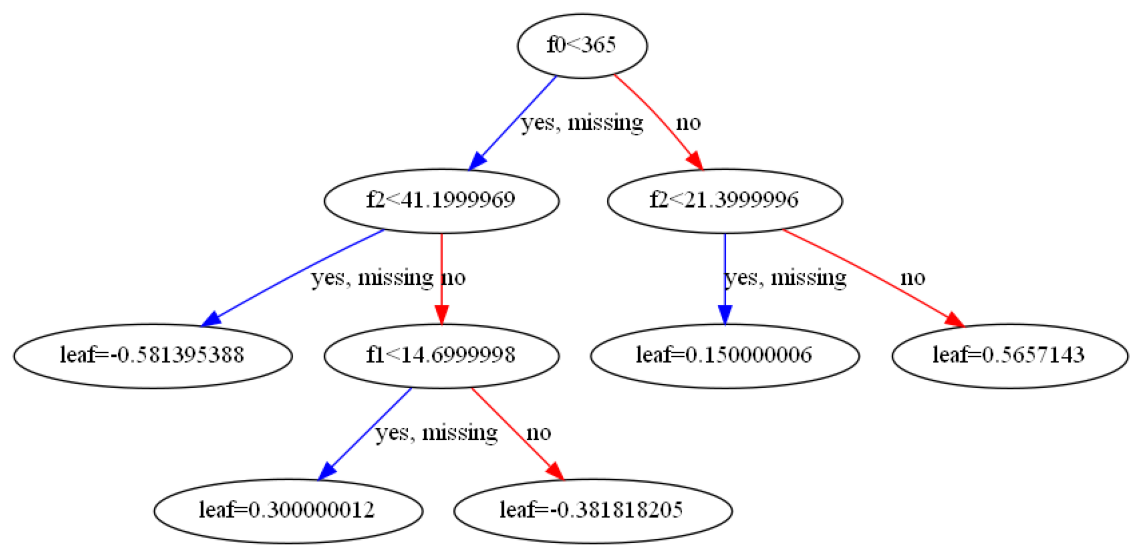

In [13]:
plt.figure(dpi=300,figsize=(20,20))
plot_tree(model)
plt.show()

## Sprawdźmy jak ten model się sprawdza na nowych danych

In [16]:
new_data = pd.read_csv('data/Yan_reply_First_last_wtime.csv')
new_data.head()

,ClientVisitGUID,Expired_Outcome,Last_LDH,Last_CRP,Last_Lymph,First_LDH,First_CRP,First_Lymph,Last_time_LDH,Last_time_CRP,Last_time_Lymph,First_time_LDH,First_time_CRP,First_time_Lymph
0,1298314042,1,641,57.5,4.5,598,54.30,4.5,2 days 11:12:59,0 days 05:24:53,1 days 21:43:56,2 days 15:51:00,2 days 15:49:10,1 days 21:43:57
1,231729013,1,334,100.4,0.9,334,223.60,0.9,4 days 23:49:43,2 days 23:51:48,6 days 17:33:16,4 days 23:49:43,4 days 22:42:30,35 days 22:23:14
2,292613519,1,742,168.2,2.8,525,16.77,8.1,0 days 03:04:19,0 days 03:04:10,-1 days +23:56:08,14 days 15:58:27,15 days 18:47:49,11 days 00:51:43
3,1624500118,1,613,19.3,0.9,296,19.30,22.1,0 days 08:42:44,2 days 14:31:34,0 days 10:37:16,5 days 00:35:01,2 days 14:31:34,24 days 22:08:05
4,1101470227,1,271,25.1,2.6,374,46.70,5.4,0 days 23:21:10,-1 days +22:54:57,-1 days +20:35:07,24 days 13:05:59,24 days 13:28:36,27 days 01:15:44


In [17]:
#na nowych data set
cols=['Last_LDH','Last_Lymph','Last_CRP']
X_new = new_data[['Last_LDH','Last_Lymph','Last_CRP']]
Y_new = new_data['Expired_Outcome']
cols.append('Expired_Outcome')

x_col = cols[:-1]
y_col = cols[-1]
x_new = new_data[x_col].values
y_new = new_data[y_col].values

y_pred_new = model.predict(x_new)
print(classification_report(y_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.94      0.39      0.55       678
           1       0.45      0.96      0.61       360

    accuracy                           0.58      1038
   macro avg       0.70      0.67      0.58      1038
weighted avg       0.77      0.58      0.57      1038



# Spróbujmy to zrobić lepiej

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt

In [21]:
data_pre_df.head()

,PATIENT_ID,Lactate dehydrogenase,High sensitivity C-reactive protein,(%)lymphocyte,Admission time,Discharge time,outcome
0,1,194.0,2.7,28.6,2020-02-09 10:47:24,2020-02-21 14:51:12,0
1,2,172.0,0.7,30.5,2020-02-09 03:39:47,2020-02-21 11:57:40,0
2,3,1131.0,9.1,4.7,2020-01-27 23:06:56,2020-02-14 17:53:08,1
3,4,161.0,2.1,2.2,2020-02-01 19:49:13,2020-02-22 14:22:38,0
4,5,241.0,4.6,26.7,2020-01-22 19:42:32,2020-02-04 15:09:30,0


## Ada Boost Classifier

In [35]:
x_train, x_test, y_train, y_test = train_test_split(data_df_unna[['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']], data_df_unna['Type2'] )

clf = AdaBoostClassifier(random_state=1,learning_rate=0.15,algorithm ='SAMME.R')
clf.fit(x_train,y_train)

prediction_test1=clf.predict(x_test)
print(classification_report(y_test, prediction_test1))

#dla ramki 110
prediction_test2=clf.predict(data_pre_df[['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']])
print(classification_report(data_pre_df['outcome'], prediction_test2))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95        47
         1.0       0.91      0.98      0.94        41

    accuracy                           0.94        88
   macro avg       0.94      0.95      0.94        88
weighted avg       0.95      0.94      0.94        88

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        97
           1       0.80      0.92      0.86        13

    accuracy                           0.96       110
   macro avg       0.89      0.95      0.92       110
weighted avg       0.97      0.96      0.96       110



In [36]:
#sprawdźmy jak sobie radzi na nowych danych
X_new = new_data[['Last_LDH','Last_Lymph','Last_CRP']]
Y_new = new_data['Expired_Outcome']

prediction_test=clf.predict(X_new)
print(classification_report(Y_new, prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.37      0.53       678
           1       0.45      0.98      0.62       360

    accuracy                           0.58      1038
   macro avg       0.71      0.67      0.58      1038
weighted avg       0.79      0.58      0.56      1038



# Analiza rokładu zmiennych
Zauważmy, że zmienne wybrane do modelu są bardzo skrzywione na lewo, zarówno w pierwszej tabeli (przed odfiltrowaniem NaN-ów) oraz w dodatkowej tabeli danych

In [89]:
def my_read_train_data(path_train):
    data_df = pd.read_excel(path_train, index_col=[0, 1],engine='openpyxl')  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df

my_df=my_read_train_data('./data/time_series_375_prerpocess_en.xlsx')
#my_df2=my_read_train_data('./data/time_series_test_110_preprocess_en.xlsx')
my_df

,age,gender,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,...,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine,Type2
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
1,73.0,1.0,19.9,131.0,100.0,12.4,0.09,1.7,NaN,71.0,...,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0,0.0
2,61.0,1.0,1.9,149.0,98.1,12.3,0.09,0.1,441.0,45.0,...,36.0,27.4,NaN,137.4,0.27,40.0,22.0,94.6,74.0,0.0
3,70.0,2.0,NaN,126.0,102.2,13.6,0.06,0.1,591.0,69.0,...,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0,0.0
4,74.0,1.0,4.8,103.0,103.1,16.3,0.38,2.5,NaN,79.0,...,NaN,14.5,0.11,144.2,0.27,72.0,26.0,74.2,88.0,0.0
5,29.0,2.0,5.6,130.0,102.2,14.6,0.02,3.0,258.0,84.0,...,NaN,0.8,0.08,143.6,0.36,11.0,18.0,122.8,54.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,63.0,1.0,1741.5,143.0,95.7,14.4,1.51,0.0,758.0,65.0,...,43.8,152.0,NaN,135.8,0.16,19.0,31.0,88.6,81.0,1.0
372,79.0,1.0,45.0,102.0,119.8,29.5,1.14,0.2,1833.0,180.0,...,55.3,177.6,0.06,155.4,0.07,93.0,121.0,12.9,364.0,1.0
373,61.0,2.0,124.8,100.0,102.6,14.9,0.56,0.1,NaN,141.0,...,36.7,205.8,NaN,141.6,0.18,NaN,9.0,101.3,47.0,1.0


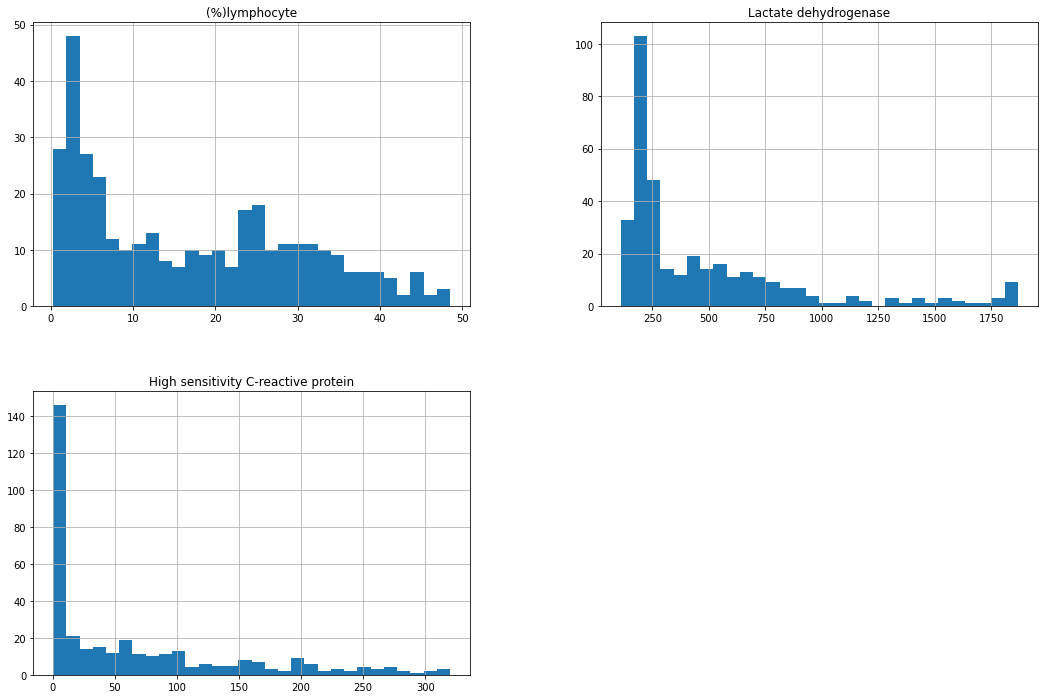

In [90]:
my_df[['(%)lymphocyte','Lactate dehydrogenase', 'High sensitivity C-reactive protein']].hist(figsize=(18, 12), bins=30)
plt.show()

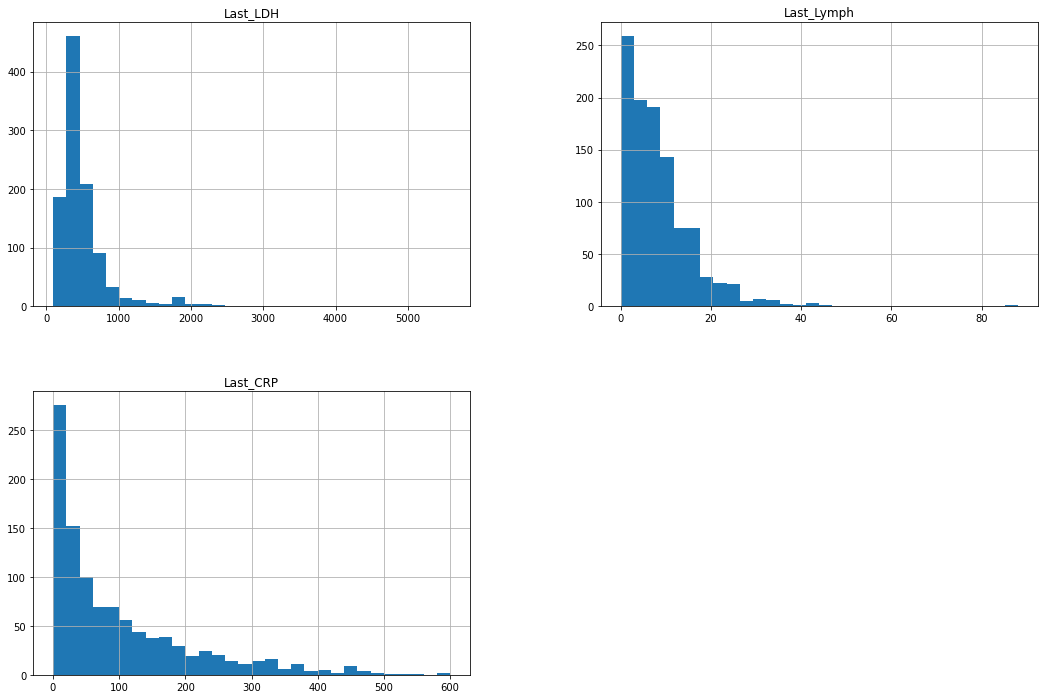

In [93]:
new_data[['Last_LDH','Last_Lymph', 'Last_CRP']].hist(figsize=(18, 12), bins=30)
plt.show()

Dlatego, aby ulepszyć model użyjemy spierwiastkowanych zmiennych. SPrawdźmy jak zmieni się skrzywienie po wsprowadzeniu takich zmian:

In [95]:
X_new = new_data[['Last_LDH','Last_Lymph','Last_CRP']]
X_new['Last_LDH'] = np.sqrt(X_new['Last_LDH'])
X_new['Last_Lymph'] = np.sqrt(X_new['Last_Lymph'])
X_new['Last_CRP'] = np.sqrt(X_new['Last_CRP'])

print(new_data['Last_LDH'].skew())
print(X_new['Last_LDH'].skew())
print(new_data['Last_Lymph'].skew())
print(X_new['Last_Lymph'].skew())
print(new_data['Last_CRP'].skew())
print(X_new['Last_CRP'].skew())

4.822946587610139
2.2862037333219165
2.505064058641674
0.4337351510341422
1.602604551414699
0.6499655749813044


# Ulepszony Ada Boost Classifier

In [39]:
#teraz ulepszmy go go sqrt

cols=['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']
data_df_unna,data_pre_df = data_preprocess()
data_df_unna = data_df_unna.dropna(subset=cols,how='any')
data_df = data_df_unna.copy(deep=True)
data_df['Lactate dehydrogenase'] = np.sqrt(data_df['Lactate dehydrogenase'])
data_df['(%)lymphocyte'] = np.sqrt(data_df['(%)lymphocyte'])
data_df['High sensitivity C-reactive protein'] = np.sqrt(data_df['High sensitivity C-reactive protein'])

data_pre = data_pre_df.copy(deep=True)
data_pre['Lactate dehydrogenase'] = np.sqrt(data_pre['Lactate dehydrogenase'])
data_pre['(%)lymphocyte'] = np.sqrt(data_pre['(%)lymphocyte'])
data_pre['High sensitivity C-reactive protein'] = np.sqrt(data_pre['High sensitivity C-reactive protein'])


x_train, x_test, y_train, y_test = train_test_split(data_df[['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']], data_df['Type2'] )

clf_sqrt = AdaBoostClassifier(random_state=1,learning_rate=0.15,algorithm ='SAMME.R')
clf_sqrt.fit(x_train,y_train)


prediction_test1=clf_sqrt.predict(x_test)
print(classification_report(y_test, prediction_test1))

#dla ramki 110
prediction_test2=clf_sqrt.predict(data_pre[['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']])
print(classification_report(data_pre['outcome'], prediction_test2))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        50
         1.0       0.93      0.97      0.95        38

    accuracy                           0.95        88
   macro avg       0.95      0.96      0.95        88
weighted avg       0.96      0.95      0.95        88

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        97
           1       0.73      0.85      0.79        13

    accuracy                           0.95       110
   macro avg       0.86      0.90      0.88       110
weighted avg       0.95      0.95      0.95       110



In [88]:
#dla nowych danych

X_new = new_data[['Last_LDH','Last_Lymph','Last_CRP']]
Y_new = new_data['Expired_Outcome']

X_new['Last_LDH'] = np.sqrt(X_new['Last_LDH'])
X_new['Last_Lymph'] = np.sqrt(X_new['Last_Lymph'])
X_new['Last_CRP'] = np.sqrt(X_new['Last_CRP'])

prediction_test=clf_sqrt.predict(X_new)
print(classification_report(Y_new, prediction_test))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58       678
           1       0.47      0.96      0.63       360

    accuracy                           0.61      1038
   macro avg       0.71      0.69      0.61      1038
weighted avg       0.78      0.61      0.60      1038

